In [1]:
using Pkg
Pkg.status()

In [2]:
using DelimitedFiles
using DifferentialEquations
using Turing
using StaticArrays
using Plots

In [3]:
const SL = readdlm("../graphs/ER-100-05.csv", ',', Float64) #|> SMatrix{100,100}

100×100 Matrix{Float64}:
  5.72819    0.0        0.0         …  0.0      0.0         0.0
  0.0        7.57306    0.0            0.0      0.0         0.0
  0.0        0.0        4.89477        0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0       -0.624785   0.0            0.0     -0.824934   -0.381766
  0.0       -0.415078  -0.957855    …  0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0        0.0       -0.700984       0.0     -0.786114    0.0
 -0.755214   0.0        0.0         …  0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0        0.0        0.0            0.0      0.0         0.0
  ⋮                                 ⋱                      
  0.0        0.0        0.0            0.0      0.0         0.0
  0.0        0

In [4]:
function NetworkFKPP(du, u, p, t)
    du .= -p[1] * SL * u .+ p[2] .* u .* (1 .- u)
end

NetworkFKPP (generic function with 1 method)

In [10]:
u0 = zeros(100)
u0[50] = 0.1

p = [0.05, 1.5]

t_span = (0.0,10.0)

prob = ODEProblem(NetworkFKPP, u0, t_span, p)
sol = solve(prob, Tsit5(), saveat=1.0);

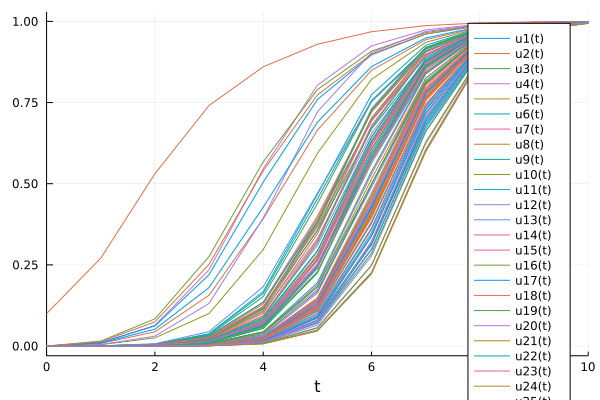

In [11]:
plot(sol)

In [24]:
@model function fit(data, prob)
    σ ~ InverseGamma(2, 3)

    k ~ truncated(Normal(1.0,2.0), 0, Inf)
    a ~ truncated(Normal(1.0,2.0), 0, Inf)

    problem = remake(prob, p=[k, a])
    predictions = solve(problem, Tsit5(), saveat=1.0)

    for i in 1:11
        data[:,i] .~ MvNormal(predictions[i], σ)
    end
end

fit (generic function with 1 method)

In [25]:
m = fit(Array(sol),prob);

In [28]:
@time chain = sample(m, NUTS(0.65), 2_000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/pavanchaggar/.julia/packages/Turing/Fv8CB/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:08:45


528.218504 seconds (64.68 M allocations: 4.734 TiB, 21.88% gc time)


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 528.2 seconds
Compute duration  = 528.2 seconds
parameters        = a, σ, k
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    0.0027    0.0001     0.0000    0.0000   390.0680    1.0011     ⋯
           k    0.0500    0.0001     0.0000    0.0000   882.7850    1.0001     ⋯
           a    1.5000    0.0005     0.0000    0.0000   972.2512    0.9998     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%    

In [33]:
using ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

true

In [34]:
@time chain = sample(m, NUTS(0.65), 1_000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/pavanchaggar/.julia/packages/Turing/Fv8CB/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:51


LoadError: InterruptException: